# Import dataset

In [ ]:
!pip install wget -q

In [ ]:
import wget, os, gzip, pickle, random, re, sys
import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, median, stdev
import seaborn as sns

In [ ]:
IMDB_URL = 'http://dlvu.github.io/data/imdb.{}.pkl.gz'
IMDB_FILE = 'imdb.{}.pkl.gz'
PAD, START, END, UNK = '.pad', '.start', '.end', '.unk'

In [ ]:
def load_imdb(final=False, val=5000, seed=0, voc=None, char=False):

    cst = 'char' if char else 'word'

    imdb_url = IMDB_URL.format(cst)
    imdb_file = IMDB_FILE.format(cst)

    if not os.path.exists(imdb_file):
        wget.download(imdb_url)

    with gzip.open(imdb_file) as file:
        sequences, labels, i2w, w2i = pickle.load(file)

    if voc is not None and voc < len(i2w):
        nw_sequences = {}

        i2w = i2w[:voc]
        w2i = {w: i for i, w in enumerate(i2w)}

        mx, unk = voc, w2i['.unk']
        for key, seqs in sequences.items():
            nw_sequences[key] = []
            for seq in seqs:
                seq = [s if s < mx else unk for s in seq]
                nw_sequences[key].append(seq)

        sequences = nw_sequences

    if final:
        return (sequences['train'], labels['train']), (sequences['test'], labels['test']), (i2w, w2i), 2

    # Make a validation split
    random.seed(seed)

    x_train, y_train = [], []
    x_val, y_val = [], []

    val_ind = set( random.sample(range(len(sequences['train'])), k=val) )
    for i, (s, l) in enumerate(zip(sequences['train'], labels['train'])):
        if i in val_ind:
            x_val.append(s)
            y_val.append(l)
        else:
            x_train.append(s)
            y_train.append(l)

    return (x_train, y_train), \
           (x_val, y_val), \
           (i2w, w2i), 2

In [ ]:
np.random.seed(1)
(x_train, y_train), (x_test, y_test), (i2w, w2i), numcls = load_imdb(final=True)

In [ ]:
print('Trainset size:', len(x_train))
print('Testset size:', len(x_test))

Trainset size: 25000
Testset size: 25000


In [ ]:
def varLenLoader(X, y, batch_size):
  X = np.array(X)
  total_len = len(X)
  for i in np.arange(0, X.shape[0], batch_size):
    x_temp = X[i:i + batch_size]
    y_mini = y[i:i + batch_size]
    ln = np.array([len(x) for x in x_temp])
    batch_length = ln.max()
    x_min = []
    for x in x_temp:
      leng = len(x)
      if leng < batch_length:
        x_min.append(x+[w2i['.pad'] for x in range(batch_length - leng)])
      else: x_min.append(x)
    x_min = torch.tensor(x_min, dtype=torch.long)
    y_mini = torch.tensor(y_mini)
    if len(y_mini) == batch_size:
      yield (x_min, y_mini)
    else: 
      pass 

# for inputs, target in varLenLoader(x_train, y_train, batch_size=500):
#   print(target.size())

# 2. Build Model

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, k, heads=8):
    super(SelfAttention, self).__init__()
    self.k, self.heads = k, heads

    self.tokeys = nn.Linear(k, k*heads, bias=False)
    self.toqueries = nn.Linear(k, k*heads, bias=False)
    self.tovalues = nn.Linear(k,k*heads, bias=False)
    self.unifyheads = nn.Linear(k*heads, k)

    def forward(self, x):
      b, t, k = x.size()
      h = self.heads

      queries = self.toqueries(x).view(b,t,h,k)
      keys    = self.tokeys(x).view(b,t,h,k)
      values  = self.tovalues(x).view(b,t,h,k)

      # fold heads into the batch dimension
      queries = queries.transpose(1,2).contiguous.view(b*h, t,k)
      keys = keys.transpose(1,2).contiguous.view(b*h, t, k)
      values = values.transpose(1,2).contiguous.view(b*h, t, k)

      # normalization 
      queries = queries/(k**(1/4))
      keys = key/(k**(1/4))

      # dot product of queries and keys to get W_{ij}
      dot = torch.bmm(queries, keys.transpose(1,2))
      # apply soft max ofer the w_ij 
      dot = F.softmax(dot, dim=2)
      
      # apply self attantion to the values 
      out = torch.bmm(dot, values).view(b,h,t,k)
      # swapback h,t 
      out = out.transpose(1,2).view(b,t,h*k)

      # unify the heads for output 
      unifyheads = self.unifyheads(out)

      return unifyheads 


In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, k, heads):
    super(TransformerBlock,self).__init__()
    
    self.attention = SelfAttention(k, heads=heads)

    self.norm1 = nn.LayerNorm(k)
    self.norm2 = nn.LayerNorm(k)

    self.ff = nn.Sequential(
        nn.Linear(k, 4*k),
        nn.ReLU(),
        nn.Linear(4*k,k)
    )

  def forward(self, x):
    attention = self.attention(x)
    x = self.norm1(attention + x)
    forward = nn.ff(x)

    return self.norm2(forward + x)

In [ ]:
class Trasformer(nn.Module):
  def __init__(self, k, heads, depth, seq_length, num_tokens, num_class):
    super(Trasformer, self).__init__()

    self.num_tokens = num_tokens
    self.token_emb = nn.Embedding(num_embeddings=num_tokens, embedding_dim=k)
    self.pos_emb = nn.Embedding(num_embeddings=seq_length, embedding_dim=k)

    tblocks = []
    for i in range(depth):
      tblocks.append(TransformerBlock(k=k, heads=heads))
    self.tblocks = nn.Sequential(*tblocks)

    self.toprobs = nn.Linear(k, num_class)

  def forward(self, x): 
    tokens = self.token_emb(x)
    b, t, k = tokens.size()

    positions = torch.Tensor(t)
    positions = self.pos_emb(positions)[none,:,:].expand(b,t,k)

    x = tokens + positions 
    x = self.tblocks(x)
    x = x.mean(dim=1)
    x = self.toprobs(x)

    return F.log_softmax(x, dim=1)


In [ ]:
def fit(model, epochs=3, lr=0.001, step_size=10, batch_size=64):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  val_idx = []

  hidden = None
  model.train()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(epochs):
    print('epoch:',epoch) 
    correct = 0
    tr_acc = 0
    running_loss = 0.0
    i = 0
    for inputs, targets in varLenLoader(x_train, y_train, batch_size):   
      outputs = model(inputs)
      loss = F.cross_entropy(outputs, targets)
      running_loss += loss.item() 
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if i % step_size == 0: 
        avg_loss = running_loss/step_size
        train_loss.append(avg_loss)
      
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        tr_acc = (100. * correct / len(targets))
        train_acc.append(tr_acc)

        # print('loss:', avg_loss,'acc:', tr_acc)
        
        # v_loss, v_acc = valid_eval(model, x_val, y_val)
        # val_loss.append(v_loss)
        # val_acc.append(v_acc) 

        running_loss = 0.0
        correct = 0

    try:
      print('loss,', mean(train_loss))
    except: pass

    print('Epoch{}, loss: {}'.format(epoch, train_loss/len(train_loss)))
    
  return train_loss, val_loss, val_acc, train_acc

In [ ]:
def valid_eval(model, x, y):
  model.eval()
  val_loss = 0
  correct = 0
  hidden = torch.autograd.Variable(torch.zeros((100,300)).type(torch.FloatTensor), requires_grad=False)
  with torch.no_grad():
    i = 0 
    for inputs, labels in varLenLoader(x, y,500):
      outputs = model(inputs)
      val_loss += F.cross_entropy(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      i +=1
  val_loss /= len(x)
  val_acc = (100. * correct / len(x))
  # print('Valid set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
  #   val_loss, correct, split,
  #   100. * correct / split))
  return val_loss, val_acc
# val_loss, val_acc = valid_eval(nonrr, x_val, y_val)
# print(val_loss, val_acc)

In [ ]:
batch_size =500
learning_rate = 0.0001
epochs = 3
step_size = 2 # inverval steps for logging the loss and accuracy 
num_embeddings = len(w2i)


In [ ]:
# rnn = RNN(num_embeddings=num_embeddings)
trans = Trasformer(k= 300,
                   heads = 8,
                   depth=6,
                   seq_length=300,
                   num_tokens=num_embeddings,
                   num_class=numcls)
# k, heads, depth, seq_length, num_tokens, num_class
v_loss, v_acc = valid_eval(trans, x_test, y_test)
print('Inital Loss:',v_loss, str(v_acc)+'%')

RuntimeError: ignored

In [ ]:

train_loss, val_loss, val_acc, train_acc = fit(rnn, lr=learning_rate, epochs=epochs, step_size=step_size, batch_size=batch_size)


epoch: 0
loss, 0.2865840819478035
epoch: 1
loss, 0.23259779959917068
epoch: 2
loss, 0.2002115347981453


In [ ]:
v_loss, v_acc = valid_eval(rnn, x_test, y_test)
print('Inital Loss:',v_loss, str(v_acc)+'%')

Inital Loss: tensor(0.0007) 84.552%


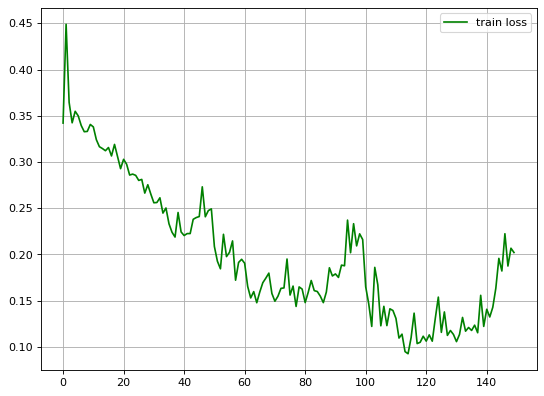

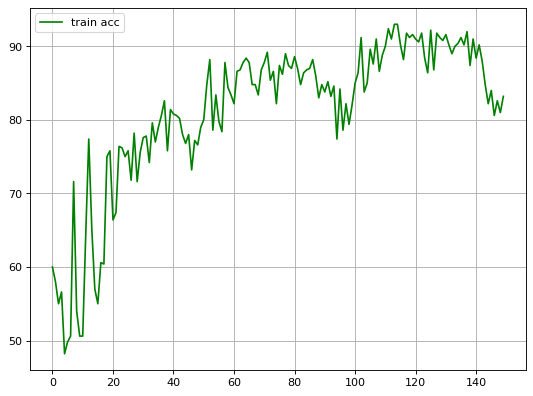

In [ ]:
# plt.plot(train_loss, color='r')
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, color='g', label='train loss')
# plt.plot(val_loss, color='r', label='val loss')
plt.legend()
plt.grid()

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_acc, color='g', label='train acc')
# plt.plot(val_acc, color='r', label='val acc')
plt.legend()
plt.grid()

